In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importacao das bibliotecas
import os
from dotenv import load_dotenv

import pandas as pd
import psycopg2 as pg
from sqlalchemy import create_engine
import panel as pn

load_dotenv()

DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_PORT = os.getenv('DB_PORT', '5432')
DB_NAME = os.getenv('DB_NAME', 'assistencia_saude')
DB_USER = os.getenv('DB_USER', 'postgres')
DB_PASS = os.getenv('DB_PASS', '2392')

CNX_STRING = f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

def conectar():
    """Cria conexao com psycopg2"""
    return pg.connect(host=DB_HOST, port=DB_PORT, dbname=DB_NAME, user=DB_USER, password=DB_PASS)

def get_engine():
    """Retorna engine do SQLAlchemy"""
    return create_engine(CNX_STRING)

print('Conexao configurada!')

Conexao configurada!


---

## Inclusao de Dados

**Responsavel:** Jesse

In [3]:
def incluir_pessoa(nome, cpf, data_nascimento, id_familia, sexo='M', gestante=False, deficiencia=None, telefone=None):
    """Inclui uma nova pessoa no sistema"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        query = """
            INSERT INTO Pessoa (nome, cpf, data_nascimento, sexo, gestante, deficiencia, telefone, familia_id)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            RETURNING id
        """
        
        cursor.execute(query, (nome, cpf, data_nascimento, sexo, gestante, deficiencia, telefone, id_familia))
        novo_id = cursor.fetchone()[0]
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Pessoa '{nome}' cadastrada com sucesso! ID: {novo_id}"
    except Exception as e:
        return f"Erro ao incluir pessoa: {str(e)}"


def incluir_profissional(nome, cpf, especialidade, agencia_id, telefone=None, email=None):
    """Inclui um novo profissional no sistema"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        query = """
            INSERT INTO Profissional (nome, cpf, telefone, email, especialidade, agencia_id)
            VALUES (%s, %s, %s, %s, %s, %s)
            RETURNING id
        """
        
        cursor.execute(query, (nome, cpf, telefone, email, especialidade, agencia_id))
        novo_id = cursor.fetchone()[0]
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Profissional '{nome}' cadastrado com sucesso! ID: {novo_id}"
    except Exception as e:
        return f"Erro ao incluir profissional: {str(e)}"


def incluir_consulta(data, hora, id_pessoa, id_profissional, tipo_consulta='Rotina', observacoes=None):
    """Inclui uma nova consulta no sistema"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        query = """
            INSERT INTO Consulta (pessoa_id, profissional_id, data_consulta, hora_consulta, tipo_consulta, observacoes)
            VALUES (%s, %s, %s, %s, %s, %s)
            RETURNING id
        """
        
        cursor.execute(query, (id_pessoa, id_profissional, data, hora, tipo_consulta, observacoes))
        novo_id = cursor.fetchone()[0]
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Consulta cadastrada com sucesso! ID: {novo_id}"
    except Exception as e:
        return f"Erro ao incluir consulta: {str(e)}"


print("Funcoes de inclusao definidas!")

Funcoes de inclusao definidas!


---

## Edicao de Dados

**Responsavel:** Juan Pablo

In [4]:
def editar_pessoa(id_pessoa, nome=None, data_nascimento=None, sexo=None, gestante=None, deficiencia=None, telefone=None, familia_id=None):
    """Edita dados de uma pessoa"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if nome is not None:
            updates.append("nome = %s")
            params.append(nome)
        if data_nascimento is not None:
            updates.append("data_nascimento = %s")
            params.append(data_nascimento)
        if sexo is not None:
            updates.append("sexo = %s")
            params.append(sexo)
        if gestante is not None:
            updates.append("gestante = %s")
            params.append(gestante)
        if deficiencia is not None:
            updates.append("deficiencia = %s")
            params.append(deficiencia)
        if telefone is not None:
            updates.append("telefone = %s")
            params.append(telefone)
        if familia_id is not None:
            updates.append("familia_id = %s")
            params.append(familia_id)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_pessoa)
        query = f"UPDATE Pessoa SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Pessoa ID {id_pessoa} atualizada com sucesso!"
    except Exception as e:
        return f"Erro ao editar pessoa: {str(e)}"

In [5]:
def editar_consulta(id_consulta, pessoa_id=None, profissional_id=None, data_consulta=None, hora_consulta=None, tipo_consulta=None, observacoes=None):
    """Edita dados de uma consulta"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if pessoa_id is not None:
            updates.append("pessoa_id = %s")
            params.append(pessoa_id)
        if profissional_id is not None:
            updates.append("profissional_id = %s")
            params.append(profissional_id)
        if data_consulta is not None:
            updates.append("data_consulta = %s")
            params.append(data_consulta)
        if hora_consulta is not None:
            updates.append("hora_consulta = %s")
            params.append(hora_consulta)
        if tipo_consulta is not None:
            updates.append("tipo_consulta = %s")
            params.append(tipo_consulta)
        if observacoes is not None:
            updates.append("observacoes = %s")
            params.append(observacoes)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_consulta)
        query = f"UPDATE Consulta SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Consulta ID {id_consulta} atualizada com sucesso!"
    except Exception as e:
        return f"Erro ao editar consulta: {str(e)}"

In [6]:
def editar_agencia(id_agencia, nome=None, cnpj=None, telefone=None, email=None, endereco_id=None):
    """Edita dados de uma agencia"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if nome is not None:
            updates.append("nome = %s")
            params.append(nome)
        if cnpj is not None:
            updates.append("cnpj = %s")
            params.append(cnpj)
        if telefone is not None:
            updates.append("telefone = %s")
            params.append(telefone)
        if email is not None:
            updates.append("email = %s")
            params.append(email)
        if endereco_id is not None:
            updates.append("endereco_id = %s")
            params.append(endereco_id)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_agencia)
        query = f"UPDATE Agencia SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Agencia ID {id_agencia} atualizada com sucesso!"
    except Exception as e:
        return f"Erro ao editar agencia: {str(e)}"


def editar_profissional(id_profissional, nome=None, telefone=None, email=None, especialidade=None, agencia_id=None):
    """Edita dados de um profissional"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if nome is not None:
            updates.append("nome = %s")
            params.append(nome)
        if telefone is not None:
            updates.append("telefone = %s")
            params.append(telefone)
        if email is not None:
            updates.append("email = %s")
            params.append(email)
        if especialidade is not None:
            updates.append("especialidade = %s")
            params.append(especialidade)
        if agencia_id is not None:
            updates.append("agencia_id = %s")
            params.append(agencia_id)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_profissional)
        query = f"UPDATE Profissional SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Profissional ID {id_profissional} atualizado com sucesso!"
    except Exception as e:
        return f"Erro ao editar profissional: {str(e)}"


def editar_familia(id_familia, codigo_familiar=None, responsavel=None, renda_familiar=None, endereco_id=None):
    """Edita dados de uma familia"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if codigo_familiar is not None:
            updates.append("codigo_familiar = %s")
            params.append(codigo_familiar)
        if responsavel is not None:
            updates.append("responsavel = %s")
            params.append(responsavel)
        if renda_familiar is not None:
            updates.append("renda_familiar = %s")
            params.append(renda_familiar)
        if endereco_id is not None:
            updates.append("endereco_id = %s")
            params.append(endereco_id)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_familia)
        query = f"UPDATE Familia SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Familia ID {id_familia} atualizada com sucesso!"
    except Exception as e:
        return f"Erro ao editar familia: {str(e)}"


def editar_endereco(id_endereco, rua=None, numero=None, complemento=None, bairro=None, cidade=None, estado=None, cep=None):
    """Edita dados de um endereco"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if rua is not None:
            updates.append("rua = %s")
            params.append(rua)
        if numero is not None:
            updates.append("numero = %s")
            params.append(numero)
        if complemento is not None:
            updates.append("complemento = %s")
            params.append(complemento)
        if bairro is not None:
            updates.append("bairro = %s")
            params.append(bairro)
        if cidade is not None:
            updates.append("cidade = %s")
            params.append(cidade)
        if estado is not None:
            updates.append("estado = %s")
            params.append(estado)
        if cep is not None:
            updates.append("cep = %s")
            params.append(cep)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_endereco)
        query = f"UPDATE Endereco SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Endereco ID {id_endereco} atualizado com sucesso!"
    except Exception as e:
        return f"Erro ao editar endereco: {str(e)}"


def editar_unidade_saude(id_unidade, nome=None, tipo=None, telefone=None, horario_funcionamento=None, endereco_id=None):
    """Edita dados de uma unidade de saude"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if nome is not None:
            updates.append("nome = %s")
            params.append(nome)
        if tipo is not None:
            updates.append("tipo = %s")
            params.append(tipo)
        if telefone is not None:
            updates.append("telefone = %s")
            params.append(telefone)
        if horario_funcionamento is not None:
            updates.append("horario_funcionamento = %s")
            params.append(horario_funcionamento)
        if endereco_id is not None:
            updates.append("endereco_id = %s")
            params.append(endereco_id)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_unidade)
        query = f"UPDATE UnidadeSaude SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Unidade de Saude ID {id_unidade} atualizada com sucesso!"
    except Exception as e:
        return f"Erro ao editar unidade de saude: {str(e)}"


def editar_medicamento(id_medicamento, nome=None, principio_ativo=None, fabricante=None, dosagem_padrao=None, tipo=None):
    """Edita dados de um medicamento"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if nome is not None:
            updates.append("nome = %s")
            params.append(nome)
        if principio_ativo is not None:
            updates.append("principio_ativo = %s")
            params.append(principio_ativo)
        if fabricante is not None:
            updates.append("fabricante = %s")
            params.append(fabricante)
        if dosagem_padrao is not None:
            updates.append("dosagem_padrao = %s")
            params.append(dosagem_padrao)
        if tipo is not None:
            updates.append("tipo = %s")
            params.append(tipo)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_medicamento)
        query = f"UPDATE Medicamento SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Medicamento ID {id_medicamento} atualizado com sucesso!"
    except Exception as e:
        return f"Erro ao editar medicamento: {str(e)}"


def editar_atendimento(id_atendimento, pessoa_id=None, profissional_id=None, unidade_saude_id=None, data_atendimento=None, tipo_atendimento=None, descricao=None):
    """Edita dados de um atendimento"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if pessoa_id is not None:
            updates.append("pessoa_id = %s")
            params.append(pessoa_id)
        if profissional_id is not None:
            updates.append("profissional_id = %s")
            params.append(profissional_id)
        if unidade_saude_id is not None:
            updates.append("unidade_saude_id = %s")
            params.append(unidade_saude_id)
        if data_atendimento is not None:
            updates.append("data_atendimento = %s")
            params.append(data_atendimento)
        if tipo_atendimento is not None:
            updates.append("tipo_atendimento = %s")
            params.append(tipo_atendimento)
        if descricao is not None:
            updates.append("descricao = %s")
            params.append(descricao)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_atendimento)
        query = f"UPDATE Atendimento SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Atendimento ID {id_atendimento} atualizado com sucesso!"
    except Exception as e:
        return f"Erro ao editar atendimento: {str(e)}"


def editar_prescricao(id_prescricao, pessoa_id=None, profissional_id=None, medicamento_id=None, data_prescricao=None, dosagem=None, frequencia=None, duracao=None, instrucoes=None):
    """Edita dados de uma prescricao"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if pessoa_id is not None:
            updates.append("pessoa_id = %s")
            params.append(pessoa_id)
        if profissional_id is not None:
            updates.append("profissional_id = %s")
            params.append(profissional_id)
        if medicamento_id is not None:
            updates.append("medicamento_id = %s")
            params.append(medicamento_id)
        if data_prescricao is not None:
            updates.append("data_prescricao = %s")
            params.append(data_prescricao)
        if dosagem is not None:
            updates.append("dosagem = %s")
            params.append(dosagem)
        if frequencia is not None:
            updates.append("frequencia = %s")
            params.append(frequencia)
        if duracao is not None:
            updates.append("duracao = %s")
            params.append(duracao)
        if instrucoes is not None:
            updates.append("instrucoes = %s")
            params.append(instrucoes)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_prescricao)
        query = f"UPDATE Prescricao SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Prescricao ID {id_prescricao} atualizada com sucesso!"
    except Exception as e:
        return f"Erro ao editar prescricao: {str(e)}"


def editar_diagnostico(id_diagnostico, pessoa_id=None, profissional_id=None, consulta_id=None, data_diagnostico=None, cid=None, descricao=None, observacoes=None):
    """Edita dados de um diagnostico"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if pessoa_id is not None:
            updates.append("pessoa_id = %s")
            params.append(pessoa_id)
        if profissional_id is not None:
            updates.append("profissional_id = %s")
            params.append(profissional_id)
        if consulta_id is not None:
            updates.append("consulta_id = %s")
            params.append(consulta_id)
        if data_diagnostico is not None:
            updates.append("data_diagnostico = %s")
            params.append(data_diagnostico)
        if cid is not None:
            updates.append("cid = %s")
            params.append(cid)
        if descricao is not None:
            updates.append("descricao = %s")
            params.append(descricao)
        if observacoes is not None:
            updates.append("observacoes = %s")
            params.append(observacoes)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_diagnostico)
        query = f"UPDATE Diagnostico SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Diagnostico ID {id_diagnostico} atualizado com sucesso!"
    except Exception as e:
        return f"Erro ao editar diagnostico: {str(e)}"


def editar_prontuario(id_prontuario, pessoa_id=None, profissional_id=None, data_registro=None, anotacoes=None, tipo_registro=None):
    """Edita dados de um prontuario"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if pessoa_id is not None:
            updates.append("pessoa_id = %s")
            params.append(pessoa_id)
        if profissional_id is not None:
            updates.append("profissional_id = %s")
            params.append(profissional_id)
        if data_registro is not None:
            updates.append("data_registro = %s")
            params.append(data_registro)
        if anotacoes is not None:
            updates.append("anotacoes = %s")
            params.append(anotacoes)
        if tipo_registro is not None:
            updates.append("tipo_registro = %s")
            params.append(tipo_registro)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_prontuario)
        query = f"UPDATE Prontuario SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Prontuario ID {id_prontuario} atualizado com sucesso!"
    except Exception as e:
        return f"Erro ao editar prontuario: {str(e)}"


def editar_procedimento(id_procedimento, pessoa_id=None, profissional_id=None, consulta_id=None, data_procedimento=None, tipo_procedimento=None, descricao=None, valor=None):
    """Edita dados de um procedimento"""
    try:
        conn = conectar()
        cursor = conn.cursor()
        
        updates = []
        params = []
        
        if pessoa_id is not None:
            updates.append("pessoa_id = %s")
            params.append(pessoa_id)
        if profissional_id is not None:
            updates.append("profissional_id = %s")
            params.append(profissional_id)
        if consulta_id is not None:
            updates.append("consulta_id = %s")
            params.append(consulta_id)
        if data_procedimento is not None:
            updates.append("data_procedimento = %s")
            params.append(data_procedimento)
        if tipo_procedimento is not None:
            updates.append("tipo_procedimento = %s")
            params.append(tipo_procedimento)
        if descricao is not None:
            updates.append("descricao = %s")
            params.append(descricao)
        if valor is not None:
            updates.append("valor = %s")
            params.append(valor)
        
        if not updates:
            return "Nenhum campo para atualizar"
        
        params.append(id_procedimento)
        query = f"UPDATE Procedimento SET {', '.join(updates)} WHERE id = %s"
        
        cursor.execute(query, params)
        conn.commit()
        cursor.close()
        conn.close()
        
        return f"Procedimento ID {id_procedimento} atualizado com sucesso!"
    except Exception as e:
        return f"Erro ao editar procedimento: {str(e)}"

---

###Exemplos

In [7]:
print(editar_pessoa(id_pessoa=1, data_nascimento='2000-04-25'))


Pessoa ID 1 atualizada com sucesso!


In [8]:

print(editar_profissional(id_profissional=1 ,especialidade='Cardiologista'))

Profissional ID 1 atualizado com sucesso!


---

## Remocao de Dados

**Responsavel:** Nayrana

In [9]:
pn.extension('tabulator', notifications=True)


def remover_registro(id_registro):
  
    query = text("DELETE FROM Pessoa WHERE id = :id")
    try:
        with engine.begin() as conn:
            result = conn.execute(query, {"id": id_registro})
            if result.rowcount > 0:
                return True, f"Registro ID {id_registro} removido com sucesso!"
            else:
                return False, "ID não encontrado no banco de dados."
    except Exception as e:
        
        return False, f"Erro ao remover: {str(e)}"

BokehModel(combine_events=True, render_bundle={'docs_json': {'bfdb7ed4-4c01-49e7-a074-8f4425e3dc53': {'version…

---

## Consultas com Filtragem

**Responsavel:** Emilly

In [10]:

def buscar_consultas(nome_pessoa=None, nome_profissional=None, tipo_consulta=None, data_inicio=None, data_fim=None):
    """
    Busca consultas com filtros opcionais.
    
    Parametros:
        nome_pessoa: filtrar por nome do paciente
        nome_profissional: filtrar por nome do profissional
        tipo_consulta: filtrar por tipo de consulta
        data_inicio: data inicial do periodo
        data_fim: data final do periodo
    """
    conn = conectar()
    
    query = """
        SELECT 
            c.id,
            p.nome AS paciente,
            pr.nome AS profissional,
            pr.especialidade,
            c.data_consulta,
            c.hora_consulta,
            c.tipo_consulta
        FROM Consulta c
        JOIN Pessoa p ON c.pessoa_id = p.id
        JOIN Profissional pr ON c.profissional_id = pr.id
        WHERE 1=1
    """
    
    params = []
    
    if nome_pessoa:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome_pessoa}%')
    
    if nome_profissional:
        query += " AND pr.nome ILIKE %s"
        params.append(f'%{nome_profissional}%')
    
    if tipo_consulta:
        query += " AND c.tipo_consulta ILIKE %s"
        params.append(f'%{tipo_consulta}%')
    
    if data_inicio:
        query += " AND c.data_consulta >= %s"
        params.append(data_inicio)
    
    if data_fim:
        query += " AND c.data_consulta <= %s"
        params.append(data_fim)
    
    query += " ORDER BY c.data_consulta DESC, c.hora_consulta DESC"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_pessoas(nome=None, cpf=None, sexo=None, gestante=None):
    """
    Busca pessoas com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            p.id,
            p.nome,
            p.cpf,
            p.data_nascimento,
            p.sexo,
            p.gestante,
            p.deficiencia,
            p.telefone,
            f.codigo_familiar,
            f.responsavel AS responsavel_familia
        FROM Pessoa p
        JOIN Familia f ON p.familia_id = f.id
        WHERE 1=1
    """
    
    params = []
    
    if nome:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome}%')
    
    if cpf:
        query += " AND p.cpf ILIKE %s"
        params.append(f'%{cpf}%')
    
    if sexo:
        query += " AND p.sexo = %s"
        params.append(sexo)
    
    if gestante is not None:
        query += " AND p.gestante = %s"
        params.append(gestante)
    
    query += " ORDER BY p.nome"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_profissionais(nome=None, especialidade=None, agencia=None):
    """
    Busca profissionais com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            pr.id,
            pr.nome,
            pr.cpf,
            pr.telefone,
            pr.email,
            pr.especialidade,
            a.nome AS agencia
        FROM Profissional pr
        JOIN Agencia a ON pr.agencia_id = a.id
        WHERE 1=1
    """
    
    params = []
    
    if nome:
        query += " AND pr.nome ILIKE %s"
        params.append(f'%{nome}%')
    
    if especialidade:
        query += " AND pr.especialidade ILIKE %s"
        params.append(f'%{especialidade}%')
    
    if agencia:
        query += " AND a.nome ILIKE %s"
        params.append(f'%{agencia}%')
    
    query += " ORDER BY pr.nome"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_atendimentos(nome_pessoa=None, tipo_atendimento=None, data_inicio=None, data_fim=None):
    """
    Busca atendimentos com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            a.id,
            p.nome AS paciente,
            pr.nome AS profissional,
            us.nome AS unidade_saude,
            a.data_atendimento,
            a.tipo_atendimento,
            a.descricao
        FROM Atendimento a
        JOIN Pessoa p ON a.pessoa_id = p.id
        JOIN Profissional pr ON a.profissional_id = pr.id
        LEFT JOIN UnidadeSaude us ON a.unidade_saude_id = us.id
        WHERE 1=1
    """
    
    params = []
    
    if nome_pessoa:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome_pessoa}%')
    
    if tipo_atendimento:
        query += " AND a.tipo_atendimento ILIKE %s"
        params.append(f'%{tipo_atendimento}%')
    
    if data_inicio:
        query += " AND a.data_atendimento >= %s"
        params.append(data_inicio)
    
    if data_fim:
        query += " AND a.data_atendimento <= %s"
        params.append(data_fim)
    
    query += " ORDER BY a.data_atendimento DESC"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_prescricoes(nome_pessoa=None, nome_medicamento=None):
    """
    Busca prescricoes com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            pr.id,
            p.nome AS paciente,
            prof.nome AS profissional,
            m.nome AS medicamento,
            m.principio_ativo,
            pr.data_prescricao,
            pr.dosagem,
            pr.frequencia,
            pr.instrucoes
        FROM Prescricao pr
        JOIN Pessoa p ON pr.pessoa_id = p.id
        JOIN Profissional prof ON pr.profissional_id = prof.id
        JOIN Medicamento m ON pr.medicamento_id = m.id
        WHERE 1=1
    """
    
    params = []
    
    if nome_pessoa:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome_pessoa}%')
    
    if nome_medicamento:
        query += " AND m.nome ILIKE %s"
        params.append(f'%{nome_medicamento}%')
    
    query += " ORDER BY pr.data_prescricao DESC"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


print('Funcoes de consulta definidas!')

Funcoes de consulta definidas!


### Exemplos de Uso

In [11]:
# Listar todas as consultas
buscar_consultas()

,id,paciente,profissional,especialidade,data_consulta,hora_consulta,tipo_consulta
0,8,Ana Silva,Dra. Maria Costa,Ginecologista,2025-02-10,10:00:00,Pre-natal
1,6,Julia Santos,Dra. Maria Costa,Ginecologista,2025-01-15,16:00:00,Pre-natal
2,5,Carlos Santos,Dr. Pedro Oliveira,Cardiologista,2025-01-14,15:30:00,Cardiologia
3,4,Pedro Oliveira,Dra. Ana Santos,Pediatra,2025-01-13,14:00:00,Pediatrica
4,3,Maria Oliveira,Dr. Carlos Silva,Cardiologista,2025-01-12,10:00:00,Retorno
5,2,Ana Silva,Dra. Maria Costa,Ginecologista,2025-01-11,09:30:00,Pre-natal
6,1,Manoel Gomes,Dr. Carlos Silva,Cardiologista,2025-01-10,08:00:00,Rotina


In [12]:
# Filtrar consultas por nome do paciente
buscar_consultas(nome_pessoa='Maria')

,id,paciente,profissional,especialidade,data_consulta,hora_consulta,tipo_consulta
0,3,Maria Oliveira,Dr. Carlos Silva,Cardiologista,2025-01-12,10:00:00,Retorno


In [13]:
# Filtrar consultas por periodo
buscar_consultas(data_inicio='2025-01-01', data_fim='2025-12-31')

,id,paciente,profissional,especialidade,data_consulta,hora_consulta,tipo_consulta
0,8,Ana Silva,Dra. Maria Costa,Ginecologista,2025-02-10,10:00:00,Pre-natal
1,6,Julia Santos,Dra. Maria Costa,Ginecologista,2025-01-15,16:00:00,Pre-natal
2,5,Carlos Santos,Dr. Pedro Oliveira,Cardiologista,2025-01-14,15:30:00,Cardiologia
3,4,Pedro Oliveira,Dra. Ana Santos,Pediatra,2025-01-13,14:00:00,Pediatrica
4,3,Maria Oliveira,Dr. Carlos Silva,Cardiologista,2025-01-12,10:00:00,Retorno
5,2,Ana Silva,Dra. Maria Costa,Ginecologista,2025-01-11,09:30:00,Pre-natal
6,1,Manoel Gomes,Dr. Carlos Silva,Cardiologista,2025-01-10,08:00:00,Rotina


In [14]:
# Listar todas as pessoas
buscar_pessoas()

,id,nome,cpf,data_nascimento,sexo,gestante,deficiencia,telefone,codigo_familiar,responsavel_familia
0,2,Ana Silva,123.456.789-02,1985-03-20,F,True,None,11-98888-1112,FAM001,Joao da Silva
1,5,Carlos Santos,345.678.901-01,1990-01-25,M,False,Visual,11-98888-3333,FAM003,Carlos Santos
2,6,Julia Santos,345.678.901-02,1992-07-30,F,True,None,11-98888-3334,FAM003,Carlos Santos
3,1,Manoel Gomes,123.456.789-01,2000-04-25,M,False,Auditiva,11-98888-1111,FAM001,Joao da Silva
4,3,Maria Oliveira,234.567.890-01,1975-08-10,F,False,None,11-98888-2222,FAM002,Maria Oliveira
5,4,Pedro Oliveira,234.567.890-02,2010-12-01,M,False,None,11-98888-2223,FAM002,Maria Oliveira


In [15]:
# Filtrar pessoas gestantes
buscar_pessoas(gestante=True)

,id,nome,cpf,data_nascimento,sexo,gestante,deficiencia,telefone,codigo_familiar,responsavel_familia
0,2,Ana Silva,123.456.789-02,1985-03-20,F,True,None,11-98888-1112,FAM001,Joao da Silva
1,6,Julia Santos,345.678.901-02,1992-07-30,F,True,None,11-98888-3334,FAM003,Carlos Santos


In [16]:
# Listar profissionais por especialidade
buscar_profissionais(especialidade='Clinico')

,id,nome,cpf,telefone,email,especialidade,agencia
0,5,João,11111111111,None,joaogui@gmail.com,Clinico Geral,UBS Centro


In [17]:
# Listar atendimentos
buscar_atendimentos()

,id,paciente,profissional,unidade_saude,data_atendimento,tipo_atendimento,descricao
0,5,Carlos Santos,Dr. Pedro Oliveira,Hospital Municipal,2025-01-14,Consulta,Avaliacao cardiologica
1,4,Pedro Oliveira,Dra. Ana Santos,UBS Norte,2025-01-13,Emergencia,Febre alta
2,3,Maria Oliveira,Dr. Carlos Silva,UBS Norte,2025-01-12,Retorno,Retorno para ver exames
3,2,Ana Silva,Dra. Maria Costa,UBS Centro,2025-01-11,Emergência,Iniciando Processo de parto
4,1,Manoel Gomes,Dr. Carlos Silva,UBS Centro,2025-01-10,Consulta,Paciente com dor de cabeca


In [18]:
# Listar prescricoes
buscar_prescricoes()

,id,paciente,profissional,medicamento,principio_ativo,data_prescricao,dosagem,frequencia,instrucoes
0,5,Julia Santos,Dra. Maria Costa,Amoxicilina 500mg,Amoxicilina,2025-01-15,500mg,12 em 12 horas,Tomar por 7 dias
1,3,Carlos Santos,Dr. Pedro Oliveira,Losartana 50mg,Losartana,2025-01-14,50mg,1 vez ao dia,Uso continuo
2,2,Pedro Oliveira,Dra. Ana Santos,Paracetamol 500mg,Paracetamol,2025-01-13,250mg,6 em 6 horas,Tomar por 3 dias
3,4,Maria Oliveira,Dr. Carlos Silva,Omeprazol 20mg,Omeprazol,2025-01-12,500mg,2 vezes ao dia,Tomar em jejum
4,1,Manoel Gomes,Dr. Carlos Silva,Paracetamol 500mg,Paracetamol,2025-01-10,500mg,8 em 8 horas,Tomar por 5 dias


---

## Graficos com Agregacao

**Responsavel:** Emilly

In [19]:
import matplotlib.pyplot as plt

def grafico_consultas_por_tipo():
    """Grafico de pizza - Consultas por tipo"""
    conn = conectar()
    query = """
        SELECT tipo_consulta, COUNT(*) as total
        FROM Consulta
        GROUP BY tipo_consulta
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(8, 6))
    plt.pie(df['total'], labels=df['tipo_consulta'], autopct='%1.1f%%', startangle=90)
    plt.title('Consultas por Tipo')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_consultas_por_mes():
    """Grafico de barras - Consultas por mes"""
    conn = conectar()
    query = """
        SELECT 
            TO_CHAR(data_consulta, 'YYYY-MM') as mes,
            COUNT(*) as total
        FROM Consulta
        GROUP BY TO_CHAR(data_consulta, 'YYYY-MM')
        ORDER BY mes
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['mes'], df['total'], color='steelblue')
    plt.xlabel('Mês')
    plt.ylabel('Quantidade')
    plt.title('Consultas por Mês')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_pacientes_por_sexo():
    """Grafico de pizza - Pacientes por sexo"""
    conn = conectar()
    query = """
        SELECT 
            CASE sexo WHEN 'M' THEN 'Masculino' ELSE 'Feminino' END as sexo,
            COUNT(*) as total
        FROM Pessoa
        GROUP BY sexo
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(8, 6))
    colors = ['#3498db', '#e74c3c']
    plt.pie(df['total'], labels=df['sexo'], autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Pacientes por Sexo')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_atendimentos_por_tipo():
    """Grafico de barras horizontais - Atendimentos por tipo"""
    conn = conectar()
    query = """
        SELECT tipo_atendimento, COUNT(*) as total
        FROM Atendimento
        GROUP BY tipo_atendimento
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.barh(df['tipo_atendimento'], df['total'], color='coral')
    plt.xlabel('Quantidade')
    plt.ylabel('Tipo de Atendimento')
    plt.title('Atendimentos por Tipo')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_consultas_por_profissional():
    """Grafico de barras - Consultas por profissional"""
    conn = conectar()
    query = """
        SELECT pr.nome, COUNT(*) as total
        FROM Consulta c
        JOIN Profissional pr ON c.profissional_id = pr.id
        GROUP BY pr.nome
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['nome'], df['total'], color='mediumseagreen')
    plt.xlabel('Profissional')
    plt.ylabel('Quantidade de Consultas')
    plt.title('Consultas por Profissional')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_prescricoes_por_medicamento():
    """Grafico de barras - Prescricoes por medicamento"""
    conn = conectar()
    query = """
        SELECT m.nome as medicamento, COUNT(*) as total
        FROM Prescricao p
        JOIN Medicamento m ON p.medicamento_id = m.id
        GROUP BY m.nome
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['medicamento'], df['total'], color='mediumpurple')
    plt.xlabel('Medicamento')
    plt.ylabel('Quantidade de Prescrições')
    plt.title('Prescrições por Medicamento')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_gestantes():
    """Grafico de pizza - Gestantes vs Nao gestantes (mulheres)"""
    conn = conectar()
    query = """
        SELECT 
            CASE WHEN gestante THEN 'Gestante' ELSE 'Não Gestante' END as status,
            COUNT(*) as total
        FROM Pessoa
        WHERE sexo = 'F'
        GROUP BY gestante
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(8, 6))
    colors = ['#f39c12', '#9b59b6']
    plt.pie(df['total'], labels=df['status'], autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Status de Gestação (Mulheres)')
    plt.tight_layout()
    plt.show()
    
    return df


print('Funcoes de grafico definidas!')

Funcoes de grafico definidas!


### Exemplos de Gráficos

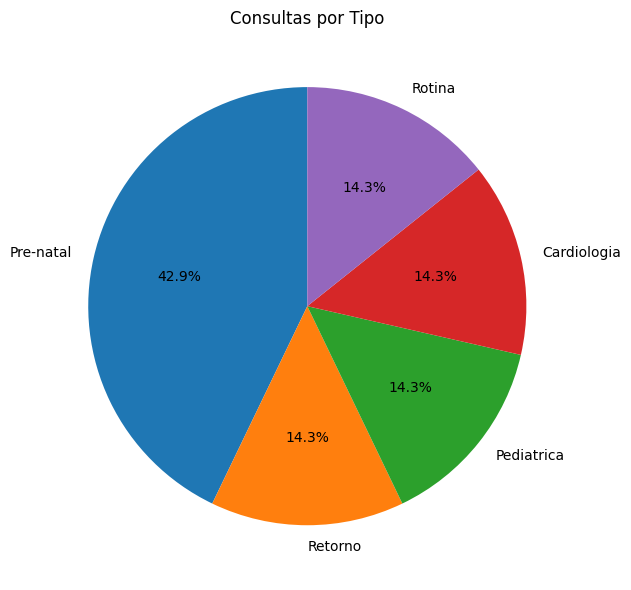

,tipo_consulta,total
0,Pre-natal,3
1,Retorno,1
2,Pediatrica,1
3,Cardiologia,1
4,Rotina,1


In [20]:
# Consultas por tipo (pizza)
grafico_consultas_por_tipo()

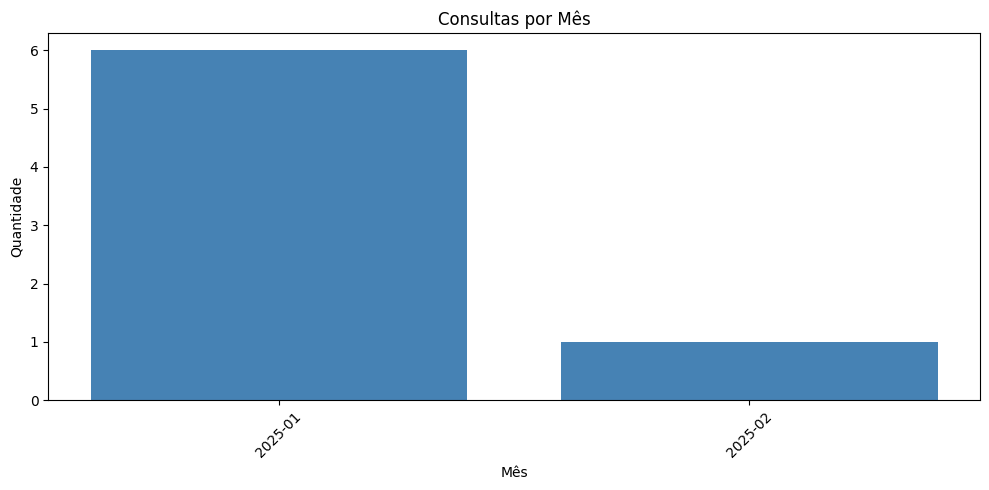

,mes,total
0,2025-01,6
1,2025-02,1


In [21]:
# Consultas por mes (barras)
grafico_consultas_por_mes()

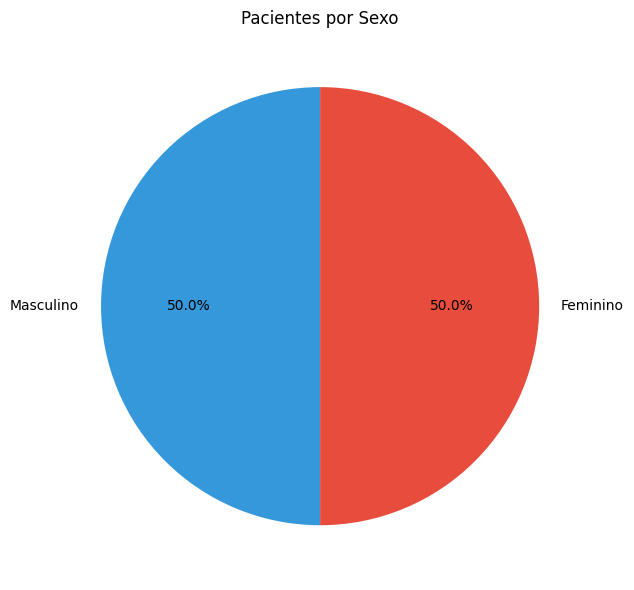

,sexo,total
0,Masculino,3
1,Feminino,3


In [22]:
# Pacientes por sexo (pizza)
grafico_pacientes_por_sexo()

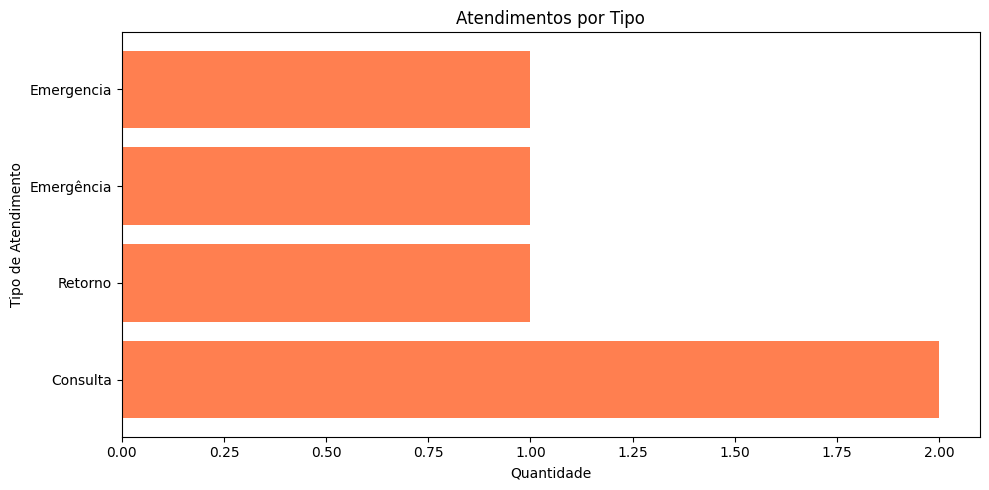

,tipo_atendimento,total
0,Consulta,2
1,Retorno,1
2,Emergência,1
3,Emergencia,1


In [23]:
# Atendimentos por tipo (barras horizontais)
grafico_atendimentos_por_tipo()

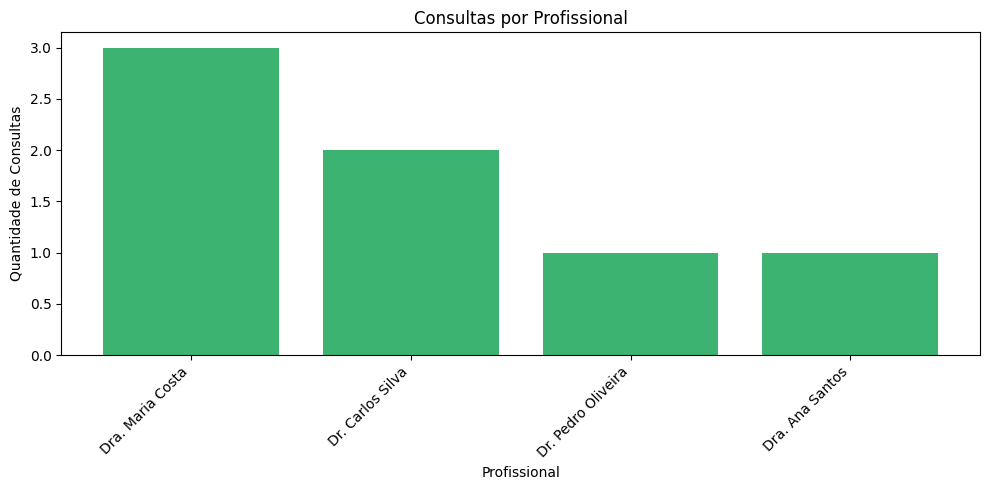

,nome,total
0,Dra. Maria Costa,3
1,Dr. Carlos Silva,2
2,Dr. Pedro Oliveira,1
3,Dra. Ana Santos,1


In [24]:
# Consultas por profissional
grafico_consultas_por_profissional()

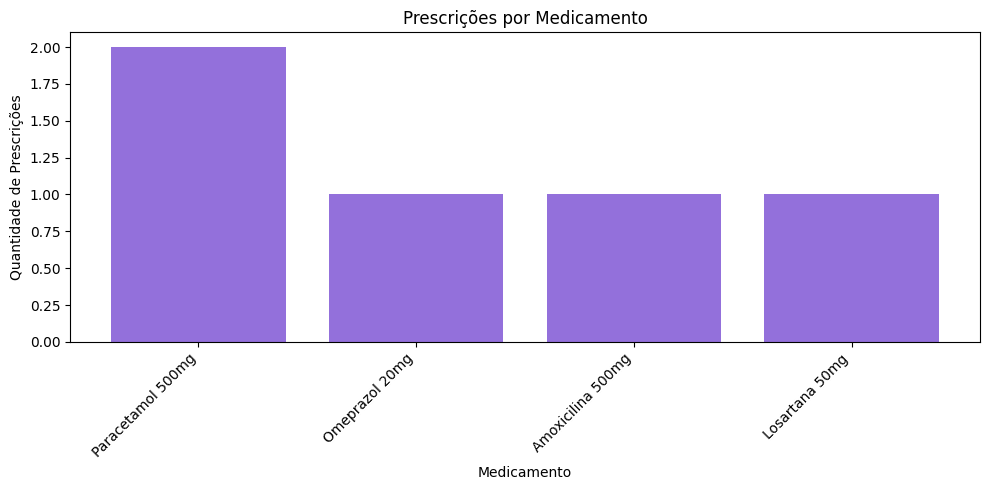

,medicamento,total
0,Paracetamol 500mg,2
1,Omeprazol 20mg,1
2,Amoxicilina 500mg,1
3,Losartana 50mg,1


In [25]:
# Prescricoes por medicamento
grafico_prescricoes_por_medicamento()

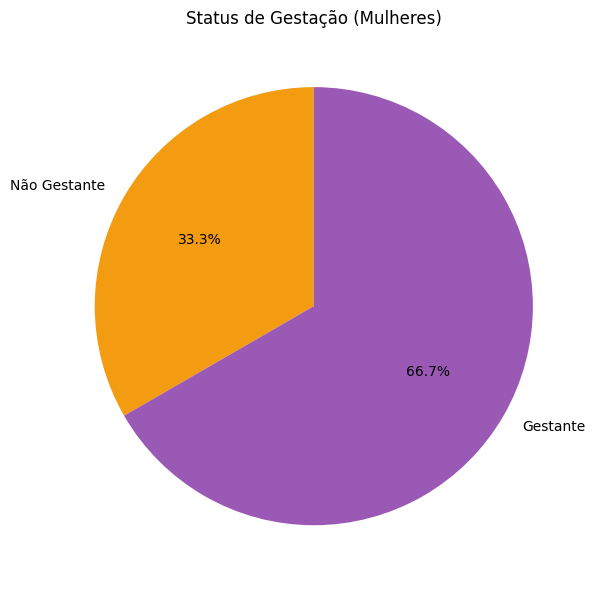

,status,total
0,Não Gestante,1
1,Gestante,2


In [26]:
# Status de gestacao (mulheres)
grafico_gestantes()

---

## Interface Grafica com Panel

**Tela interativa para o Sistema de Assistencia a Saude**

In [27]:

pn.extension()
pn.extension('tabulator')
pn.extension(notifications=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'9d9b7b30-b9f2-49d0-9010-87e67a027884': {'version…

In [28]:

flag = ''

w_pessoa_nome = pn.widgets.TextInput(
    name="Nome",
    value='',
    placeholder='Digite o nome do paciente',
    width=250
)

w_pessoa_cpf = pn.widgets.TextInput(
    name="CPF",
    value='',
    placeholder='Digite o CPF',
    width=250
)

w_pessoa_sexo = pn.widgets.Select(
    name='Sexo',
    options=['Todos', 'M', 'F'],
    value='Todos',
    width=150
)

w_pessoa_gestante = pn.widgets.Select(
    name='Gestante',
    options=['Todos', 'Sim', 'Nao'],
    value='Todos',
    width=150
)

# --- Aba Consultas ---
w_consulta_paciente = pn.widgets.TextInput(
    name="Paciente",
    value='',
    placeholder='Nome do paciente',
    width=250
)

w_consulta_profissional = pn.widgets.TextInput(
    name="Profissional",
    value='',
    placeholder='Nome do profissional',
    width=250
)

w_consulta_tipo = pn.widgets.TextInput(
    name="Tipo de Consulta",
    value='',
    placeholder='Ex: Rotina, Retorno...',
    width=200
)

w_consulta_data_inicio = pn.widgets.DatePicker(
    name='Data Inicio',
    width=150
)

w_consulta_data_fim = pn.widgets.DatePicker(
    name='Data Fim',
    width=150
)

# --- Aba Profissionais ---
w_prof_nome = pn.widgets.TextInput(
    name="Nome",
    value='',
    placeholder='Nome do profissional',
    width=250
)

w_prof_especialidade = pn.widgets.TextInput(
    name="Especialidade",
    value='',
    placeholder='Ex: Clinico Geral',
    width=200
)

w_prof_agencia = pn.widgets.TextInput(
    name="Agencia",
    value='',
    placeholder='Nome da agencia',
    width=200
)

w_atend_paciente = pn.widgets.TextInput(
    name="Paciente",
    value='',
    placeholder='Nome do paciente',
    width=250
)

w_atend_tipo = pn.widgets.TextInput(
    name="Tipo de Atendimento",
    value='',
    placeholder='Ex: Vacinacao',
    width=200
)

w_atend_data_inicio = pn.widgets.DatePicker(
    name='Data Inicio',
    width=150
)

w_atend_data_fim = pn.widgets.DatePicker(
    name='Data Fim',
    width=150
)

w_presc_paciente = pn.widgets.TextInput(
    name="Paciente",
    value='',
    placeholder='Nome do paciente',
    width=250
)

w_presc_medicamento = pn.widgets.TextInput(
    name="Medicamento",
    value='',
    placeholder='Nome do medicamento',
    width=250
)

w_excluir_id = pn.widgets.IntInput(
    name="ID para Excluir",
    value=None,
    placeholder='Digite o ID',
    width=150
)

# === Widgets para INCLUIR Pessoa ===
w_incluir_pessoa_nome = pn.widgets.TextInput(name="Nome*", placeholder='Nome completo', width=250)
w_incluir_pessoa_cpf = pn.widgets.TextInput(name="CPF*", placeholder='000.000.000-00', width=200)
w_incluir_pessoa_data_nasc = pn.widgets.DatePicker(name='Data Nascimento*', width=200)
w_incluir_pessoa_sexo_inc = pn.widgets.Select(name='Sexo', options=['M', 'F'], value='M', width=100)
w_incluir_pessoa_gestante_inc = pn.widgets.Checkbox(name='Gestante', value=False, width=100)
w_incluir_pessoa_deficiencia = pn.widgets.TextInput(name="Deficiência", placeholder='Opcional', width=200)
w_incluir_pessoa_telefone = pn.widgets.TextInput(name="Telefone", placeholder='(00) 00000-0000', width=200)
w_incluir_pessoa_familia_id = pn.widgets.IntInput(name="ID Família*", value=1, start=1, width=150)

# === Widgets para EDITAR Pessoa ===
w_editar_pessoa_id = pn.widgets.IntInput(name="ID da Pessoa*", placeholder='Digite o ID', width=150)
w_editar_pessoa_nome = pn.widgets.TextInput(name="Nome", placeholder='Novo nome (opcional)', width=250)
w_editar_pessoa_data_nasc = pn.widgets.DatePicker(name='Data Nascimento', width=200)
w_editar_pessoa_sexo = pn.widgets.Select(name='Sexo', options=[None, 'M', 'F'], value=None, width=100)
w_editar_pessoa_telefone = pn.widgets.TextInput(name="Telefone", placeholder='Novo telefone', width=200)

# === Widgets para INCLUIR Consulta ===
w_incluir_consulta_pessoa_id = pn.widgets.IntInput(name="ID Pessoa*", value=1, start=1, width=150)
w_incluir_consulta_prof_id = pn.widgets.IntInput(name="ID Profissional*", value=1, start=1, width=150)
w_incluir_consulta_data = pn.widgets.DatePicker(name='Data*', width=200)
w_incluir_consulta_hora = pn.widgets.TextInput(name="Hora*", placeholder='HH:MM:SS', value='09:00:00', width=150)
w_incluir_consulta_tipo_inc = pn.widgets.TextInput(name="Tipo", placeholder='Rotina, Retorno...', value='Rotina', width=200)
w_incluir_consulta_obs = pn.widgets.TextAreaInput(name="Observações", placeholder='Observações opcionais', width=300, height=80)

# === Widgets para EDITAR Consulta ===
w_editar_consulta_id = pn.widgets.IntInput(name="ID da Consulta*", placeholder='Digite o ID', width=150)
w_editar_consulta_data = pn.widgets.DatePicker(name='Nova Data', width=200)
w_editar_consulta_hora = pn.widgets.TextInput(name="Nova Hora", placeholder='HH:MM:SS', width=150)
w_editar_consulta_tipo = pn.widgets.TextInput(name="Novo Tipo", placeholder='Tipo de consulta', width=200)

# === Widgets para INCLUIR Profissional ===
w_incluir_prof_nome = pn.widgets.TextInput(name="Nome*", placeholder='Nome completo', width=250)
w_incluir_prof_cpf = pn.widgets.TextInput(name="CPF*", placeholder='000.000.000-00', width=200)
w_incluir_prof_especialidade = pn.widgets.TextInput(name="Especialidade*", placeholder='Ex: Cardiologista', width=200)
w_incluir_prof_agencia_id = pn.widgets.IntInput(name="ID Agência*", value=1, start=1, width=150)
w_incluir_prof_telefone = pn.widgets.TextInput(name="Telefone", placeholder='Opcional', width=200)
w_incluir_prof_email = pn.widgets.TextInput(name="Email", placeholder='email@exemplo.com', width=250)

# === Widgets para EDITAR Profissional ===
w_editar_prof_id = pn.widgets.IntInput(name="ID do Profissional*", placeholder='Digite o ID', width=150)
w_editar_prof_nome = pn.widgets.TextInput(name="Nome", placeholder='Novo nome', width=250)
w_editar_prof_especialidade = pn.widgets.TextInput(name="Especialidade", placeholder='Nova especialidade', width=200)
w_editar_prof_telefone = pn.widgets.TextInput(name="Telefone", placeholder='Novo telefone', width=200)

# === Widget para REMOVER Pessoa ===
w_excluir_pessoa_id = pn.widgets.IntInput(name="ID para Excluir", placeholder='Digite o ID da pessoa', width=150)

print("Widgets criados!")

Widgets criados!


In [29]:

btn_consultar_pessoas = pn.widgets.Button(name='Consultar Pessoas', button_type='primary', width=200)
btn_excluir_pessoa = pn.widgets.Button(name='Excluir Pessoa', button_type='danger', width=200)
btn_incluir_pessoa = pn.widgets.Button(name='✚ Incluir Pessoa', button_type='success', width=200)
btn_editar_pessoa = pn.widgets.Button(name='✎ Editar Pessoa', button_type='warning', width=200)

btn_consultar_consultas = pn.widgets.Button(name='Consultar', button_type='primary', width=200)
btn_excluir_consulta = pn.widgets.Button(name='Excluir Consulta', button_type='danger', width=200)
btn_incluir_consulta = pn.widgets.Button(name='✚ Incluir Consulta', button_type='success', width=200)
btn_editar_consulta = pn.widgets.Button(name='✎ Editar Consulta', button_type='warning', width=200)

btn_consultar_profissionais = pn.widgets.Button(name='Consultar Profissionais', button_type='primary', width=200)
btn_incluir_profissional = pn.widgets.Button(name='✚ Incluir Profissional', button_type='success', width=200)
btn_editar_profissional = pn.widgets.Button(name='✎ Editar Profissional', button_type='warning', width=200)

btn_consultar_atendimentos = pn.widgets.Button(name='Consultar Atendimentos', button_type='primary', width=200)

btn_consultar_prescricoes = pn.widgets.Button(name='Consultar Prescricoes', button_type='primary', width=200)

btn_grafico_tipo_consulta = pn.widgets.Button(name='Consultas por Tipo', button_type='success', width=180)
btn_grafico_consultas_mes = pn.widgets.Button(name='Consultas por Mes', button_type='success', width=180)
btn_grafico_sexo = pn.widgets.Button(name='Pacientes por Sexo', button_type='success', width=180)
btn_grafico_atendimentos = pn.widgets.Button(name='Atendimentos por Tipo', button_type='success', width=180)
btn_grafico_profissional = pn.widgets.Button(name='Consultas por Profissional', button_type='success', width=180)
btn_grafico_prescricoes = pn.widgets.Button(name='Prescricoes por Medicamento', button_type='success', width=180)
btn_grafico_gestantes = pn.widgets.Button(name='Status Gestacao', button_type='success', width=180)

print("Botoes criados!")

Botoes criados!


In [30]:

def query_pessoas():
    """Consulta pessoas com filtros dos widgets"""
    try:
        conn = conectar()
        query = """
            SELECT 
                p.id,
                p.nome,
                p.cpf,
                p.data_nascimento,
                p.sexo,
                p.gestante,
                p.deficiencia,
                p.telefone,
                f.codigo_familiar
            FROM Pessoa p
            JOIN Familia f ON p.familia_id = f.id
            WHERE 1=1
        """
        params = []
        
        if w_pessoa_nome.value:
            query += " AND p.nome ILIKE %s"
            params.append(f'%{w_pessoa_nome.value}%')
        
        if w_pessoa_cpf.value:
            query += " AND p.cpf ILIKE %s"
            params.append(f'%{w_pessoa_cpf.value}%')
        
        if w_pessoa_sexo.value != 'Todos':
            query += " AND p.sexo = %s"
            params.append(w_pessoa_sexo.value)
        
        if w_pessoa_gestante.value != 'Todos':
            query += " AND p.gestante = %s"
            params.append(w_pessoa_gestante.value == 'Sim')
        
        query += " ORDER BY p.nome"
        
        df = pd.read_sql_query(query, conn, params=params)
        conn.close()
        return pn.widgets.Tabulator(df, sizing_mode='stretch_width', height=400)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao consultar pessoas: {str(e)}', alert_type='danger')


def query_consultas():
    """Consulta consultas medicas com filtros dos widgets"""
    try:
        conn = conectar()
        query = """
            SELECT 
                c.id,
                p.nome AS paciente,
                pr.nome AS profissional,
                pr.especialidade,
                c.data_consulta,
                c.hora_consulta,
                c.tipo_consulta
            FROM Consulta c
            JOIN Pessoa p ON c.pessoa_id = p.id
            JOIN Profissional pr ON c.profissional_id = pr.id
            WHERE 1=1
        """
        params = []
        
        if w_consulta_paciente.value:
            query += " AND p.nome ILIKE %s"
            params.append(f'%{w_consulta_paciente.value}%')
        
        if w_consulta_profissional.value:
            query += " AND pr.nome ILIKE %s"
            params.append(f'%{w_consulta_profissional.value}%')
        
        if w_consulta_tipo.value:
            query += " AND c.tipo_consulta ILIKE %s"
            params.append(f'%{w_consulta_tipo.value}%')
        
        if w_consulta_data_inicio.value:
            query += " AND c.data_consulta >= %s"
            params.append(w_consulta_data_inicio.value)
        
        if w_consulta_data_fim.value:
            query += " AND c.data_consulta <= %s"
            params.append(w_consulta_data_fim.value)
        
        query += " ORDER BY c.data_consulta DESC, c.hora_consulta DESC"
        
        df = pd.read_sql_query(query, conn, params=params)
        conn.close()
        return pn.widgets.Tabulator(df, sizing_mode='stretch_width', height=400)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao consultar consultas: {str(e)}', alert_type='danger')


def query_profissionais():
    """Consulta profissionais com filtros dos widgets"""
    try:
        conn = conectar()
        query = """
            SELECT 
                pr.id,
                pr.nome,
                pr.cpf,
                pr.telefone,
                pr.email,
                pr.especialidade,
                a.nome AS agencia
            FROM Profissional pr
            JOIN Agencia a ON pr.agencia_id = a.id
            WHERE 1=1
        """
        params = []
        
        if w_prof_nome.value:
            query += " AND pr.nome ILIKE %s"
            params.append(f'%{w_prof_nome.value}%')
        
        if w_prof_especialidade.value:
            query += " AND pr.especialidade ILIKE %s"
            params.append(f'%{w_prof_especialidade.value}%')
        
        if w_prof_agencia.value:
            query += " AND a.nome ILIKE %s"
            params.append(f'%{w_prof_agencia.value}%')
        
        query += " ORDER BY pr.nome"
        
        df = pd.read_sql_query(query, conn, params=params)
        conn.close()
        return pn.widgets.Tabulator(df, sizing_mode='stretch_width', height=400)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao consultar profissionais: {str(e)}', alert_type='danger')


def query_atendimentos():
    """Consulta atendimentos com filtros dos widgets"""
    try:
        conn = conectar()
        query = """
            SELECT 
                a.id,
                p.nome AS paciente,
                pr.nome AS profissional,
                us.nome AS unidade_saude,
                a.data_atendimento,
                a.tipo_atendimento,
                a.descricao
            FROM Atendimento a
            JOIN Pessoa p ON a.pessoa_id = p.id
            JOIN Profissional pr ON a.profissional_id = pr.id
            LEFT JOIN UnidadeSaude us ON a.unidade_saude_id = us.id
            WHERE 1=1
        """
        params = []
        
        if w_atend_paciente.value:
            query += " AND p.nome ILIKE %s"
            params.append(f'%{w_atend_paciente.value}%')
        
        if w_atend_tipo.value:
            query += " AND a.tipo_atendimento ILIKE %s"
            params.append(f'%{w_atend_tipo.value}%')
        
        if w_atend_data_inicio.value:
            query += " AND a.data_atendimento >= %s"
            params.append(w_atend_data_inicio.value)
        
        if w_atend_data_fim.value:
            query += " AND a.data_atendimento <= %s"
            params.append(w_atend_data_fim.value)
        
        query += " ORDER BY a.data_atendimento DESC"
        
        df = pd.read_sql_query(query, conn, params=params)
        conn.close()
        return pn.widgets.Tabulator(df, sizing_mode='stretch_width', height=400)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao consultar atendimentos: {str(e)}', alert_type='danger')


def query_prescricoes():
    """Consulta prescricoes com filtros dos widgets"""
    try:
        conn = conectar()
        query = """
            SELECT 
                pr.id,
                p.nome AS paciente,
                prof.nome AS profissional,
                m.nome AS medicamento,
                m.principio_ativo,
                pr.data_prescricao,
                pr.dosagem,
                pr.frequencia,
                pr.instrucoes
            FROM Prescricao pr
            JOIN Pessoa p ON pr.pessoa_id = p.id
            JOIN Profissional prof ON pr.profissional_id = prof.id
            JOIN Medicamento m ON pr.medicamento_id = m.id
            WHERE 1=1
        """
        params = []
        
        if w_presc_paciente.value:
            query += " AND p.nome ILIKE %s"
            params.append(f'%{w_presc_paciente.value}%')
        
        if w_presc_medicamento.value:
            query += " AND m.nome ILIKE %s"
            params.append(f'%{w_presc_medicamento.value}%')
        
        query += " ORDER BY pr.data_prescricao DESC"
        
        df = pd.read_sql_query(query, conn, params=params)
        conn.close()
        return pn.widgets.Tabulator(df, sizing_mode='stretch_width', height=400)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao consultar prescricoes: {str(e)}', alert_type='danger')


def excluir_consulta_interface():
    """Exclui uma consulta pelo ID"""
    try:
        if w_excluir_id.value is None:
            return pn.pane.Alert('Informe o ID da consulta para excluir!', alert_type='warning')
        
        conn = conectar()
        cursor = conn.cursor()
        cursor.execute("DELETE FROM Consulta WHERE id = %s", (w_excluir_id.value,))
        rows_deleted = cursor.rowcount
        conn.commit()
        cursor.close()
        conn.close()
        
        if rows_deleted > 0:
            return pn.pane.Alert(f'Consulta ID {w_excluir_id.value} excluida com sucesso!', alert_type='success')
        else:
            return pn.pane.Alert(f'Nenhuma consulta encontrada com ID {w_excluir_id.value}', alert_type='warning')
    except Exception as e:
        return pn.pane.Alert(f'Erro ao excluir consulta: {str(e)}', alert_type='danger')


def excluir_pessoa_interface():
    """Exclui uma pessoa pelo ID"""
    try:
        if w_excluir_pessoa_id.value is None:
            return pn.pane.Alert('Informe o ID da pessoa para excluir!', alert_type='warning')
        
        conn = conectar()
        cursor = conn.cursor()
        cursor.execute("DELETE FROM Pessoa WHERE id = %s", (w_excluir_pessoa_id.value,))
        rows_deleted = cursor.rowcount
        conn.commit()
        cursor.close()
        conn.close()
        
        if rows_deleted > 0:
            w_excluir_pessoa_id.value = None  # Limpar campo
            return pn.pane.Alert(f'Pessoa ID {w_excluir_pessoa_id.value} excluida com sucesso!', alert_type='success')
        else:
            return pn.pane.Alert(f'Nenhuma pessoa encontrada com ID {w_excluir_pessoa_id.value}', alert_type='warning')
    except Exception as e:
        return pn.pane.Alert(f'Erro ao excluir pessoa: {str(e)}', alert_type='danger')


# === Funções de INCLUIR ===
def incluir_pessoa_interface():
    """Inclui uma nova pessoa"""
    try:
        if not w_incluir_pessoa_nome.value or not w_incluir_pessoa_cpf.value or not w_incluir_pessoa_data_nasc.value:
            return pn.pane.Alert('Preencha todos os campos obrigatórios (*)', alert_type='warning')
        
        resultado = incluir_pessoa(
            nome=w_incluir_pessoa_nome.value,
            cpf=w_incluir_pessoa_cpf.value,
            data_nascimento=w_incluir_pessoa_data_nasc.value,
            id_familia=w_incluir_pessoa_familia_id.value,
            sexo=w_incluir_pessoa_sexo_inc.value,
            gestante=w_incluir_pessoa_gestante_inc.value,
            deficiencia=w_incluir_pessoa_deficiencia.value if w_incluir_pessoa_deficiencia.value else None,
            telefone=w_incluir_pessoa_telefone.value if w_incluir_pessoa_telefone.value else None
        )
        
        # Limpar campos após inserção
        w_incluir_pessoa_nome.value = ''
        w_incluir_pessoa_cpf.value = ''
        w_incluir_pessoa_data_nasc.value = None
        w_incluir_pessoa_deficiencia.value = ''
        w_incluir_pessoa_telefone.value = ''
        
        return pn.pane.Alert(resultado, alert_type='success' if 'sucesso' in resultado else 'danger')
    except Exception as e:
        return pn.pane.Alert(f'Erro: {str(e)}', alert_type='danger')


def incluir_consulta_interface():
    """Inclui uma nova consulta"""
    try:
        if not w_incluir_consulta_data.value or not w_incluir_consulta_hora.value:
            return pn.pane.Alert('Preencha todos os campos obrigatórios (*)', alert_type='warning')
        
        resultado = incluir_consulta(
            data=w_incluir_consulta_data.value,
            hora=w_incluir_consulta_hora.value,
            id_pessoa=w_incluir_consulta_pessoa_id.value,
            id_profissional=w_incluir_consulta_prof_id.value,
            tipo_consulta=w_incluir_consulta_tipo_inc.value,
            observacoes=w_incluir_consulta_obs.value if w_incluir_consulta_obs.value else None
        )
        
        # Limpar campos
        w_incluir_consulta_data.value = None
        w_incluir_consulta_hora.value = '09:00:00'
        w_incluir_consulta_obs.value = ''
        
        return pn.pane.Alert(resultado, alert_type='success' if 'sucesso' in resultado else 'danger')
    except Exception as e:
        return pn.pane.Alert(f'Erro: {str(e)}', alert_type='danger')


def incluir_profissional_interface():
    """Inclui um novo profissional"""
    try:
        if not w_incluir_prof_nome.value or not w_incluir_prof_cpf.value or not w_incluir_prof_especialidade.value:
            return pn.pane.Alert('Preencha todos os campos obrigatórios (*)', alert_type='warning')
        
        resultado = incluir_profissional(
            nome=w_incluir_prof_nome.value,
            cpf=w_incluir_prof_cpf.value,
            especialidade=w_incluir_prof_especialidade.value,
            agencia_id=w_incluir_prof_agencia_id.value,
            telefone=w_incluir_prof_telefone.value if w_incluir_prof_telefone.value else None,
            email=w_incluir_prof_email.value if w_incluir_prof_email.value else None
        )
        
        # Limpar campos
        w_incluir_prof_nome.value = ''
        w_incluir_prof_cpf.value = ''
        w_incluir_prof_especialidade.value = ''
        w_incluir_prof_telefone.value = ''
        w_incluir_prof_email.value = ''
        
        return pn.pane.Alert(resultado, alert_type='success' if 'sucesso' in resultado else 'danger')
    except Exception as e:
        return pn.pane.Alert(f'Erro: {str(e)}', alert_type='danger')


# === Funções de EDITAR ===
def editar_pessoa_interface():
    """Edita uma pessoa existente"""
    try:
        if not w_editar_pessoa_id.value:
            return pn.pane.Alert('Informe o ID da pessoa!', alert_type='warning')
        
        resultado = editar_pessoa(
            id_pessoa=w_editar_pessoa_id.value,
            nome=w_editar_pessoa_nome.value if w_editar_pessoa_nome.value else None,
            data_nascimento=w_editar_pessoa_data_nasc.value if w_editar_pessoa_data_nasc.value else None,
            sexo=w_editar_pessoa_sexo.value,
            telefone=w_editar_pessoa_telefone.value if w_editar_pessoa_telefone.value else None
        )
        
        # Limpar campos
        w_editar_pessoa_nome.value = ''
        w_editar_pessoa_data_nasc.value = None
        w_editar_pessoa_telefone.value = ''
        
        return pn.pane.Alert(resultado, alert_type='success' if 'sucesso' in resultado else 'danger')
    except Exception as e:
        return pn.pane.Alert(f'Erro: {str(e)}', alert_type='danger')


def editar_consulta_interface():
    """Edita uma consulta existente"""
    try:
        if not w_editar_consulta_id.value:
            return pn.pane.Alert('Informe o ID da consulta!', alert_type='warning')
        
        resultado = editar_consulta(
            id_consulta=w_editar_consulta_id.value,
            data_consulta=w_editar_consulta_data.value if w_editar_consulta_data.value else None,
            hora_consulta=w_editar_consulta_hora.value if w_editar_consulta_hora.value else None,
            tipo_consulta=w_editar_consulta_tipo.value if w_editar_consulta_tipo.value else None
        )
        
        # Limpar campos
        w_editar_consulta_data.value = None
        w_editar_consulta_hora.value = ''
        w_editar_consulta_tipo.value = ''
        
        return pn.pane.Alert(resultado, alert_type='success' if 'sucesso' in resultado else 'danger')
    except Exception as e:
        return pn.pane.Alert(f'Erro: {str(e)}', alert_type='danger')


def editar_profissional_interface():
    """Edita um profissional existente"""
    try:
        if not w_editar_prof_id.value:
            return pn.pane.Alert('Informe o ID do profissional!', alert_type='warning')
        
        resultado = editar_profissional(
            id_profissional=w_editar_prof_id.value,
            nome=w_editar_prof_nome.value if w_editar_prof_nome.value else None,
            especialidade=w_editar_prof_especialidade.value if w_editar_prof_especialidade.value else None,
            telefone=w_editar_prof_telefone.value if w_editar_prof_telefone.value else None
        )
        
        # Limpar campos
        w_editar_prof_nome.value = ''
        w_editar_prof_especialidade.value = ''
        w_editar_prof_telefone.value = ''
        
        return pn.pane.Alert(resultado, alert_type='success' if 'sucesso' in resultado else 'danger')
    except Exception as e:
        return pn.pane.Alert(f'Erro: {str(e)}', alert_type='danger')


print("Funcoes de consulta da interface criadas!")

Funcoes de consulta da interface criadas!


In [31]:
# Teste: verificar se a consulta funciona diretamente
try:
    test_result = query_pessoas()
    print("Tipo do resultado:", type(test_result))
    print("Resultado:", test_result)
except Exception as e:
    print("Erro ao testar query_pessoas():", e)
    import traceback
    traceback.print_exc()

Tipo do resultado: <class 'panel.widgets.tables.Tabulator'>
Resultado: Tabulator(height=400, sizing_mode='stretch_width', value=   id         ...)


In [32]:
# Verificar se existem dados na tabela Pessoa
conn = conectar()
df_test = pd.read_sql_query("SELECT COUNT(*) as total FROM Pessoa", conn)
print("Total de pessoas no banco:", df_test['total'][0])

df_pessoas = pd.read_sql_query("SELECT * FROM Pessoa LIMIT 5", conn)
print("\nPrimeiras 5 pessoas:")
print(df_pessoas)
conn.close()

Total de pessoas no banco: 6

Primeiras 5 pessoas:
   id  familia_id            nome             cpf data_nascimento sexo  \
0   2           1       Ana Silva  123.456.789-02      1985-03-20    F   
1   3           2  Maria Oliveira  234.567.890-01      1975-08-10    F   
2   4           2  Pedro Oliveira  234.567.890-02      2010-12-01    M   
3   5           3   Carlos Santos  345.678.901-01      1990-01-25    M   
4   6           3    Julia Santos  345.678.901-02      1992-07-30    F   

   gestante deficiencia       telefone  
0      True        None  11-98888-1112  
1     False        None  11-98888-2222  
2     False        None  11-98888-2223  
3     False      Visual  11-98888-3333  
4      True        None  11-98888-3334  


In [33]:
# Alternativa: Consultar pessoas sem usar Panel (funciona no notebook)
conn = conectar()
query = """
    SELECT 
        p.id,
        p.nome,
        p.cpf,
        p.data_nascimento,
        p.sexo,
        p.gestante,
        p.deficiencia,
        p.telefone,
        f.codigo_familiar
    FROM Pessoa p
    JOIN Familia f ON p.familia_id = f.id
    ORDER BY p.nome
"""
df_pessoas_display = pd.read_sql_query(query, conn)
conn.close()

print(f"Total de {len(df_pessoas_display)} pessoas encontradas:\n")
df_pessoas_display

Total de 6 pessoas encontradas:



,id,nome,cpf,data_nascimento,sexo,gestante,deficiencia,telefone,codigo_familiar
0,2,Ana Silva,123.456.789-02,1985-03-20,F,True,None,11-98888-1112,FAM001
1,5,Carlos Santos,345.678.901-01,1990-01-25,M,False,Visual,11-98888-3333,FAM003
2,6,Julia Santos,345.678.901-02,1992-07-30,F,True,None,11-98888-3334,FAM003
3,1,Manoel Gomes,123.456.789-01,2000-04-25,M,False,Auditiva,11-98888-1111,FAM001
4,3,Maria Oliveira,234.567.890-01,1975-08-10,F,False,None,11-98888-2222,FAM002
5,4,Pedro Oliveira,234.567.890-02,2010-12-01,M,False,None,11-98888-2223,FAM002


In [34]:

import matplotlib.pyplot as plt
from io import BytesIO

def criar_grafico_tipo_consulta():
    """Grafico de pizza - Consultas por tipo"""
    try:
        conn = conectar()
        query = """
            SELECT tipo_consulta, COUNT(*) as total
            FROM Consulta
            GROUP BY tipo_consulta
            ORDER BY total DESC
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.pie(df['total'], labels=df['tipo_consulta'], autopct='%1.1f%%', startangle=90)
        ax.set_title('Consultas por Tipo')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_consultas_mes():
    """Grafico de barras - Consultas por mes"""
    try:
        conn = conectar()
        query = """
            SELECT 
                TO_CHAR(data_consulta, 'YYYY-MM') as mes,
                COUNT(*) as total
            FROM Consulta
            GROUP BY TO_CHAR(data_consulta, 'YYYY-MM')
            ORDER BY mes
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(df['mes'], df['total'], color='steelblue')
        ax.set_xlabel('Mes')
        ax.set_ylabel('Quantidade')
        ax.set_title('Consultas por Mes')
        plt.xticks(rotation=45)
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_sexo():
    """Grafico de pizza - Pacientes por sexo"""
    try:
        conn = conectar()
        query = """
            SELECT 
                CASE sexo WHEN 'M' THEN 'Masculino' ELSE 'Feminino' END as sexo,
                COUNT(*) as total
            FROM Pessoa
            GROUP BY sexo
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = ['#3498db', '#e74c3c']
        ax.pie(df['total'], labels=df['sexo'], autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title('Pacientes por Sexo')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_atendimentos():
    """Grafico de barras horizontais - Atendimentos por tipo"""
    try:
        conn = conectar()
        query = """
            SELECT tipo_atendimento, COUNT(*) as total
            FROM Atendimento
            GROUP BY tipo_atendimento
            ORDER BY total DESC
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.barh(df['tipo_atendimento'], df['total'], color='coral')
        ax.set_xlabel('Quantidade')
        ax.set_ylabel('Tipo de Atendimento')
        ax.set_title('Atendimentos por Tipo')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_profissional():
    """Grafico de barras - Consultas por profissional"""
    try:
        conn = conectar()
        query = """
            SELECT pr.nome, COUNT(*) as total
            FROM Consulta c
            JOIN Profissional pr ON c.profissional_id = pr.id
            GROUP BY pr.nome
            ORDER BY total DESC
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(df['nome'], df['total'], color='mediumseagreen')
        ax.set_xlabel('Profissional')
        ax.set_ylabel('Quantidade de Consultas')
        ax.set_title('Consultas por Profissional')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_prescricoes():
    """Grafico de barras - Prescricoes por medicamento"""
    try:
        conn = conectar()
        query = """
            SELECT m.nome as medicamento, COUNT(*) as total
            FROM Prescricao p
            JOIN Medicamento m ON p.medicamento_id = m.id
            GROUP BY m.nome
            ORDER BY total DESC
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(df['medicamento'], df['total'], color='mediumpurple')
        ax.set_xlabel('Medicamento')
        ax.set_ylabel('Quantidade de Prescricoes')
        ax.set_title('Prescricoes por Medicamento')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


def criar_grafico_gestantes():
    """Grafico de pizza - Gestantes vs Nao gestantes (mulheres)"""
    try:
        conn = conectar()
        query = """
            SELECT 
                CASE WHEN gestante THEN 'Gestante' ELSE 'Nao Gestante' END as status,
                COUNT(*) as total
            FROM Pessoa
            WHERE sexo = 'F'
            GROUP BY gestante
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        
        if df.empty:
            return pn.pane.Alert('Nenhum dado encontrado para o grafico', alert_type='warning')
        
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = ['#f39c12', '#9b59b6']
        ax.pie(df['total'], labels=df['status'], autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title('Status de Gestacao (Mulheres)')
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, tight=True)
    except Exception as e:
        return pn.pane.Alert(f'Erro ao gerar grafico: {str(e)}', alert_type='danger')


print("Funcoes de graficos para interface criadas!")

Funcoes de graficos para interface criadas!


In [35]:

resultado_pessoas = pn.Column()
resultado_consultas = pn.Column()
resultado_profissionais = pn.Column()
resultado_atendimentos = pn.Column()
resultado_prescricoes = pn.Column()
resultado_graficos = pn.Column()

def callback_consultar_pessoas(event):
    resultado_pessoas.clear()
    resultado_pessoas.append(query_pessoas())

def callback_incluir_pessoa(event):
    resultado_pessoas.clear()
    resultado_pessoas.append(incluir_pessoa_interface())
    resultado_pessoas.append(query_pessoas())

def callback_editar_pessoa(event):
    resultado_pessoas.clear()
    resultado_pessoas.append(editar_pessoa_interface())
    resultado_pessoas.append(query_pessoas())

def callback_excluir_pessoa(event):
    resultado_pessoas.clear()
    resultado_pessoas.append(excluir_pessoa_interface())
    resultado_pessoas.append(query_pessoas())

def callback_consultar_consultas(event):
    resultado_consultas.clear()
    resultado_consultas.append(query_consultas())

def callback_excluir_consulta(event):
    resultado_consultas.clear()
    resultado_consultas.append(excluir_consulta_interface())
    resultado_consultas.append(query_consultas())

def callback_incluir_consulta(event):
    resultado_consultas.clear()
    resultado_consultas.append(incluir_consulta_interface())
    resultado_consultas.append(query_consultas())

def callback_editar_consulta(event):
    resultado_consultas.clear()
    resultado_consultas.append(editar_consulta_interface())
    resultado_consultas.append(query_consultas())

def callback_consultar_profissionais(event):
    resultado_profissionais.clear()
    resultado_profissionais.append(query_profissionais())

def callback_incluir_profissional(event):
    resultado_profissionais.clear()
    resultado_profissionais.append(incluir_profissional_interface())
    resultado_profissionais.append(query_profissionais())

def callback_editar_profissional(event):
    resultado_profissionais.clear()
    resultado_profissionais.append(editar_profissional_interface())
    resultado_profissionais.append(query_profissionais())

def callback_consultar_atendimentos(event):
    resultado_atendimentos.clear()
    resultado_atendimentos.append(query_atendimentos())

def callback_consultar_prescricoes(event):
    resultado_prescricoes.clear()
    resultado_prescricoes.append(query_prescricoes())

def callback_grafico_tipo(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_tipo_consulta())

def callback_grafico_mes(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_consultas_mes())

def callback_grafico_sexo(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_sexo())

def callback_grafico_atendimentos(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_atendimentos())

def callback_grafico_profissional(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_profissional())

def callback_grafico_prescricoes(event):
    resultado_graficos.clear()
    resultado_graficos.append(criar_grafico_prescricoes())

def callback_grafico_gestantes(event):
    resultado_graficos.clear()
btn_excluir_pessoa.on_click(callback_excluir_pessoa)

btn_consultar_consultas.on_click(callback_consultar_consultas)
btn_excluir_consulta.on_click(callback_excluir_consulta)
btn_incluir_consulta.on_click(callback_incluir_consulta)
btn_editar_consulta.on_click(callback_editar_consulta)

btn_consultar_profissionais.on_click(callback_consultar_profissionais)
btn_incluir_profissional.on_click(callback_incluir_profissional)
btn_editar_profissional.on_click(callback_editar_profissional)

btn_consultar_atendimentos.on_click(callback_consultar_atendimentos)
btn_consultar_prescricoes.on_click(callback_consultar_prescricoes)

btn_grafico_tipo_consulta.on_click(callback_grafico_tipo)
btn_grafico_consultas_mes.on_click(callback_grafico_mes)
btn_grafico_sexo.on_click(callback_grafico_sexo)
btn_grafico_atendimentos.on_click(callback_grafico_atendimentos)
btn_grafico_profissional.on_click(callback_grafico_profissional)
btn_grafico_prescricoes.on_click(callback_grafico_prescricoes)
btn_grafico_gestantes.on_click(callback_grafico_gestantes)

print('Callbacks configurados!')

Callbacks configurados!


In [36]:

aba_pessoas = pn.Column(
    pn.pane.Markdown("### 🔍 Filtros de Busca"),
    pn.Row(w_pessoa_nome, w_pessoa_cpf),
    pn.Row(w_pessoa_sexo, w_pessoa_gestante),
    pn.Row(btn_consultar_pessoas),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### ✚ Incluir Nova Pessoa"),
    pn.Row(w_incluir_pessoa_nome, w_incluir_pessoa_cpf, w_incluir_pessoa_data_nasc),
    pn.Row(w_incluir_pessoa_sexo_inc, w_incluir_pessoa_gestante_inc, w_incluir_pessoa_familia_id),
    pn.Row(w_incluir_pessoa_telefone, w_incluir_pessoa_deficiencia),
    pn.Row(btn_incluir_pessoa),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### ✎ Editar Pessoa Existente"),
    pn.Row(w_editar_pessoa_id, w_editar_pessoa_nome),
    pn.Row(w_editar_pessoa_data_nasc, w_editar_pessoa_sexo, w_editar_pessoa_telefone),
    pn.Row(btn_editar_pessoa),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### 🗑️ Remover Pessoa"),
    pn.Row(w_excluir_pessoa_id, btn_excluir_pessoa),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### 📊 Resultados"),
    resultado_pessoas,
    sizing_mode='stretch_width'
)

aba_consultas = pn.Column(
    pn.pane.Markdown("### 🔍 Filtros de Busca"),
    pn.Row(w_consulta_paciente, w_consulta_profissional),
    pn.Row(w_consulta_tipo),
    pn.Row(w_consulta_data_inicio, w_consulta_data_fim),
    pn.Row(btn_consultar_consultas),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### ✚ Incluir Nova Consulta"),
    pn.Row(w_incluir_consulta_pessoa_id, w_incluir_consulta_prof_id),
    pn.Row(w_incluir_consulta_data, w_incluir_consulta_hora, w_incluir_consulta_tipo_inc),
    pn.Row(w_incluir_consulta_obs),
    pn.Row(btn_incluir_consulta),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### ✎ Editar Consulta Existente"),
    pn.Row(w_editar_consulta_id),
    pn.Row(w_editar_consulta_data, w_editar_consulta_hora, w_editar_consulta_tipo),
    pn.Row(btn_editar_consulta),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### 🗑️ Excluir Consulta"),
    pn.Row(w_excluir_id, btn_excluir_consulta),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### 📊 Resultados"),
    resultado_consultas,
    sizing_mode='stretch_width'
)

aba_profissionais = pn.Column(
    pn.pane.Markdown("### 🔍 Filtros de Busca"),
    pn.Row(w_prof_nome, w_prof_especialidade),
    pn.Row(w_prof_agencia),
    pn.Row(btn_consultar_profissionais),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### ✚ Incluir Novo Profissional"),
    pn.Row(w_incluir_prof_nome, w_incluir_prof_cpf, w_incluir_prof_especialidade),
    pn.Row(w_incluir_prof_agencia_id, w_incluir_prof_telefone, w_incluir_prof_email),
    pn.Row(btn_incluir_profissional),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### ✎ Editar Profissional Existente"),
    pn.Row(w_editar_prof_id, w_editar_prof_nome),
    pn.Row(w_editar_prof_especialidade, w_editar_prof_telefone),
    pn.Row(btn_editar_profissional),
    
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### 📊 Resultados"),
    resultado_profissionais,
    sizing_mode='stretch_width'
)

aba_atendimentos = pn.Column(
    pn.pane.Markdown("### Filtros de Busca"),
    pn.Row(w_atend_paciente, w_atend_tipo),
    pn.Row(w_atend_data_inicio, w_atend_data_fim),
    pn.Row(btn_consultar_atendimentos),
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### Resultados"),
    resultado_atendimentos,
    sizing_mode='stretch_width'
)

aba_prescricoes = pn.Column(
    pn.pane.Markdown("### Filtros de Busca"),
    pn.Row(w_presc_paciente, w_presc_medicamento),
    pn.Row(btn_consultar_prescricoes),
    pn.pane.Markdown("---"),
    pn.pane.Markdown("### Resultados"),
    resultado_prescricoes,
    sizing_mode='stretch_width'
)

aba_graficos = pn.Column(
    pn.pane.Markdown("### Selecione um Grafico"),
    pn.Row(btn_grafico_tipo_consulta, btn_grafico_consultas_mes, btn_grafico_sexo),
    pn.Row(btn_grafico_atendimentos, btn_grafico_profissional),
    pn.Row(btn_grafico_prescricoes, btn_grafico_gestantes),
    pn.pane.Markdown("---"),
    resultado_graficos,
    sizing_mode='stretch_width'
)

print("Abas criadas!")

Abas criadas!


In [37]:
interface = pn.Tabs(
    ('🧑 Pessoas', aba_pessoas),
    ('📋 Consultas', aba_consultas),
    ('👨‍⚕️ Profissionais', aba_profissionais),
    ('🏥 Atendimentos', aba_atendimentos),
    ('💊 Prescricoes', aba_prescricoes),
    ('📊 Graficos', aba_graficos),
    sizing_mode='stretch_width'
)

layout_principal = pn.Column(
    pn.pane.Markdown(
        """
        # 🏥 Sistema de Assistencia a Saude
        
        **Bem-vindo ao sistema de gerenciamento de saude!**
        
        Use as abas abaixo para navegar entre as diferentes funcionalidades:
        - **Pessoas**: Consultar pacientes cadastrados
        - **Consultas**: Buscar e gerenciar consultas medicas
        - **Profissionais**: Consultar profissionais de saude
        - **Atendimentos**: Buscar atendimentos realizados
        - **Prescricoes**: Consultar prescricoes medicas
        - **Graficos**: Visualizar estatisticas e relatorios graficos
        
        ---
        """
    ),
    interface,
    sizing_mode='stretch_width'
)


template = pn.template.BootstrapTemplate(
    title='Sistema de Assistencia a Saude',
    main=[layout_principal],
    header_background='#2c3e50',
    theme='default'
)

pn.config.raw_css = [
    """
    body {
        background-color: white !important;
    }
    .bk-root {
        background-color: white !important;
    }
    .main {
        background-color: white !important;
    }
    """
]


In [38]:
# IMPORTANTE: Execute esta célula apenas UMA vez por sessão do kernel
# Se encontrar erro "Models must be owned by only a single document":
# 1. Reinicie o kernel (Ctrl+Shift+P -> "Restart Kernel")
# 2. Execute todas as células em ordem (1-44)
# 3. Execute esta célula novamente

template.show()

Launching server at http://localhost:59520
